In [1]:
import pandas as pd
model = "mistral"
df = pd.read_json(f"answers/rag/{model}/evaluation.json")
# df['contexts'] = df['contexts'].apply(lambda x: eval(x) if isinstance(x, str) else [''])

# df['ground_truth'] = df['ground_truth'].fillna('')
print(df['ground_truth'].tolist())
# df['contexts'] = df['contexts'].apply(lambda x: [[]])

["The Emergency Response team coordinates the university's response to student emergencies and crises.", 'Visitors to the University of Florida can expect to experience information sessions and walking tours of the campus as mentioned in the context.', 'The important deadlines for submitting application materials to the University of Florida (UF) Admissions for prospective freshmen in the 2023-24 academic year are as follows: \n\nApplication Opens: August 8\nApplication Due: November 1\nStudent Self-Reported Academic Record (SSAR): November 15\nSubmit Official Test Scores: December 1\nFreshman Admissions Decisions: February 23\nConfirm Enrollment: May 1\nSend Official Transcripts: July 15.', 'Prospective freshmen must submit their official transcripts to the UF Office of Admissions by July 15 in order to finalize their enrollment at UF for the 2023-24 academic year.', 'Parents of dependent undergraduate students at UF can apply for educational loans through the Federal Direct PLUS loan

In [2]:
data_dict = {
'question': df['question'].tolist(),
'ground_truth': df['ground_truth'].tolist(),
'contexts': df['contexts'].tolist(),
'answer': df['answer'].tolist(),
'evolution_type': df['evolution_type'].tolist(),
'episode_done': df['episode_done'].tolist()

}

In [3]:
from datasets import Dataset 

dataset = Dataset.from_dict(data_dict)
dataset

Dataset({
    features: ['question', 'ground_truth', 'contexts', 'answer', 'evolution_type', 'episode_done'],
    num_rows: 12
})

In [23]:
from ragas.metrics import (
    context_relevancy,
    faithfulness,
    answer_relevancy,
    answer_similarity,
    answer_correctness,
    context_precision,
    context_recall
)
from ragas.metrics.critique import harmfulness

In [24]:
# LangChain supports many other chat models. Here, we're using Ollama
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

# supports many more optional parameters. Hover on your `ChatOllama(...)`
# class to view the latest available supported parameters
llm = ChatOllama(model="llama3:8b")
prompt = ChatPromptTemplate.from_template("Tell me a short joke about {topic}")

# using LangChain Expressive Language chain syntax
# learn more about the LCEL on
# /docs/concepts/#langchain-expression-language-lcel
chain = prompt | llm | StrOutputParser()

# for brevity, response is printed in terminal
# You can use LangServe to deploy your application for
# production
print(chain.invoke({"topic": "Space travel"}))

Why did the astronaut break up with his girlfriend before going to Mars?

Because he needed space!


In [25]:
from ragas.llms import LangchainLLMWrapper

mistral_wrapper = LangchainLLMWrapper(langchain_llm=llm)
faithfulness.llm = mistral_wrapper
answer_relevancy.llm = mistral_wrapper
context_relevancy.llm = mistral_wrapper
answer_similarity.llm = mistral_wrapper
answer_correctness.llm = mistral_wrapper
harmfulness.llm = mistral_wrapper
context_precision.llm = mistral_wrapper
context_recall.llm = mistral_wrapper

In [28]:
# evaluate
from ragas import evaluate
from langchain_community.embeddings.fastembed import FastEmbedEmbeddings
fast_embeddings = FastEmbedEmbeddings(model_name="BAAI/bge-base-en")

result = evaluate(
    dataset, 
     metrics=[
        context_precision,
        context_relevancy,
        answer_similarity
    ],
    embeddings=fast_embeddings,
    raise_exceptions=True
)

result

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

{'context_precision': 0.6944, 'context_relevancy': 0.0903, 'answer_similarity': 0.9444}

In [31]:
import json
prompt = "basic"
num_chunks = 3

with open(f"evaluations/result_{model}_{prompt}_{num_chunks}.json", "w") as f:
    json.dump(result, f)

In [29]:
df = result.to_pandas()
df.head(12)

,question,ground_truth,contexts,answer,evolution_type,episode_done,context_precision,context_relevancy,answer_similarity
0,Who coordinates the university's response to s...,The Emergency Response team coordinates the un...,[next to the Reitz Union. The Welcome Center i...,The University of Florida has various resource...,simple,True,0.000000,0.062500,0.850213
1,What can visitors to the University of Florida...,Visitors to the University of Florida can expe...,[next to the Reitz Union. The Welcome Center i...,During a walking tour of the University of Flo...,simple,True,1.000000,0.069767,0.915443
2,What are the important deadlines for submittin...,The important deadlines for submitting applica...,[FRESHMAN DATES & DEADLINES Keep this list of ...,Here are the important deadlines for submittin...,simple,True,0.833333,0.194444,0.983001
3,What is the deadline for prospective freshmen ...,Prospective freshmen must submit their officia...,[FRESHMAN DATES & DEADLINES Keep this list of ...,The deadline for prospective freshmen to submi...,simple,True,1.000000,0.083333,0.982907
4,How can parents apply for educational loans fo...,Parents of dependent undergraduate students at...,[Work-Study jobs may be awarded by SFA to stud...,Parents of dependent undergraduate students at...,simple,True,1.000000,0.085714,0.966403
5,How can users find the available financial aid...,Users can navigate to the Item Types report in...,[Organizations: https://studentinvolvement.uf...,To find the available financial aid item types...,simple,True,0.000000,0.093750,0.880902
6,What are some facilities and services offered ...,The Division of Student Life at the University...,[next to the Reitz Union. The Welcome Center i...,The Division of Student Life at the University...,simple,True,1.000000,0.085714,0.967195
7,What services does the University of Florida P...,The University of Florida Police Department (U...,"[for all students, faculty and staff, and camp...",The University of Florida Police Department (U...,simple,True,1.000000,0.075000,0.977066
8,How does establishing a new center or institut...,Establishing a new center or institute at Univ...,[public schools; public-private partnerships);...,Establishing a new center or institute at the ...,simple,True,0.000000,0.071429,0.947089
9,What program offers free pre-K education for a...,The Florida Voluntary Prekindergarten Educatio...,[next to the Reitz Union. The Welcome Center i...,The Florida Voluntary Prekindergarten Educatio...,simple,True,0.500000,0.120000,1.000000


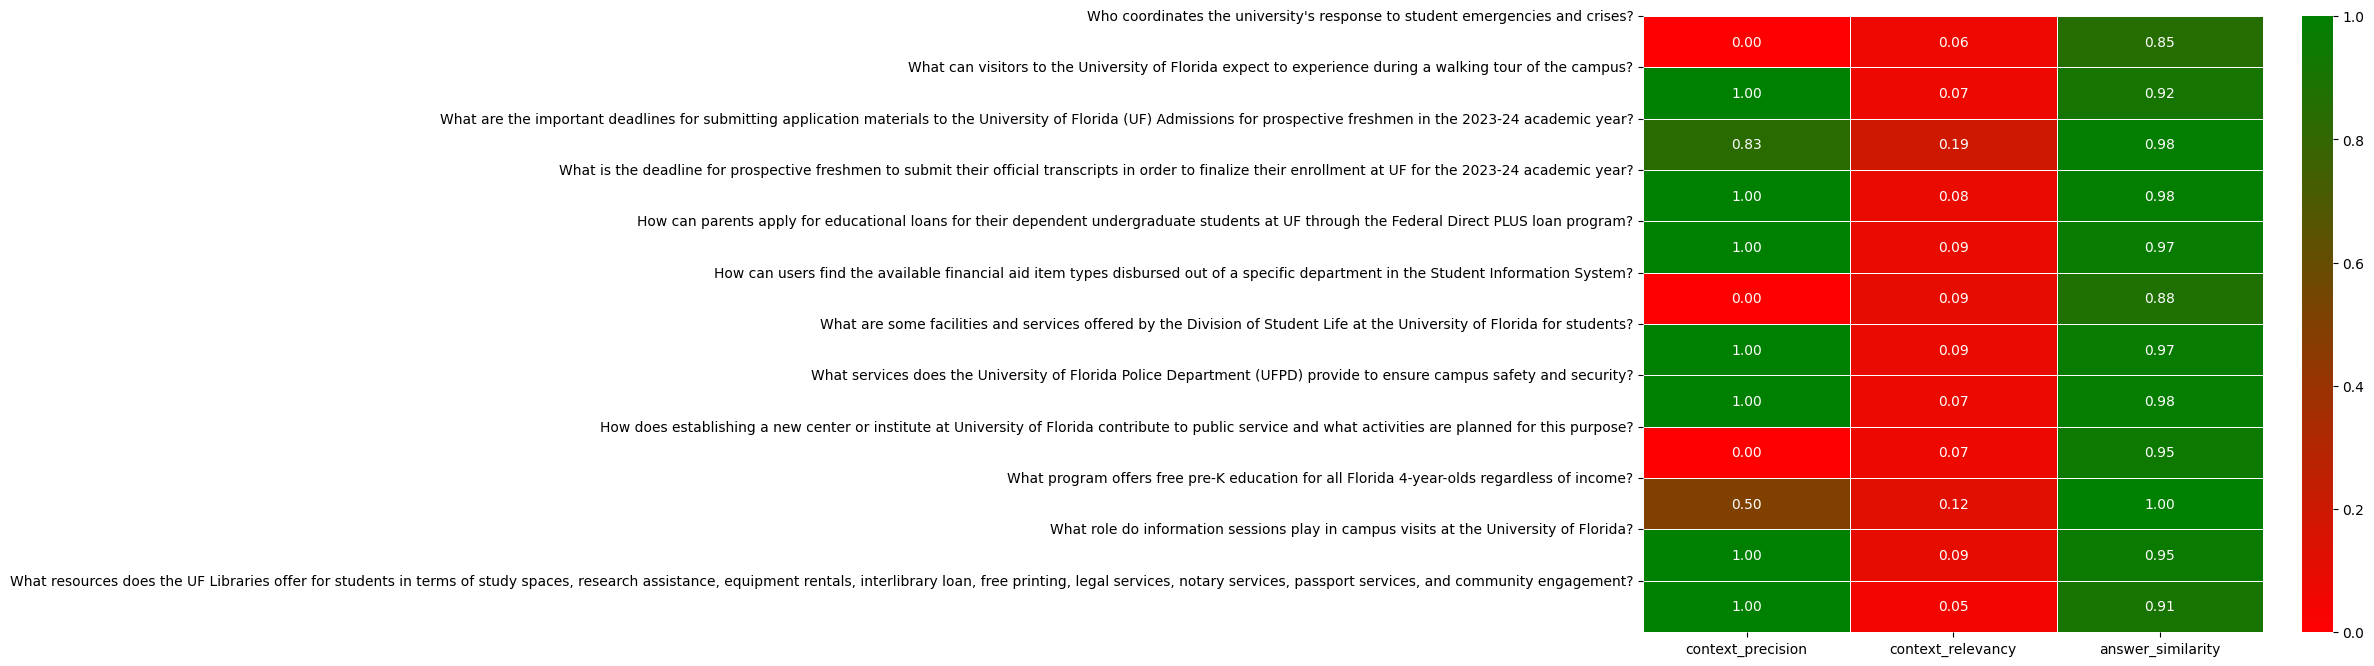

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


heatmap_data = df[['context_precision', 'context_relevancy', 'answer_similarity']]

cmap = LinearSegmentedColormap.from_list('green_red', ['red', 'green'])

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", linewidths=.5, cmap=cmap)

plt.yticks(ticks=range(len(df['question'])), labels=df['question'], rotation=0)

plt.show()